## Import Libraries

In [652]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDOneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Add more classification lib here
from sklearn.metrics import classification_report, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

import pickle
import json
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [653]:
df = pd.read_csv('undersample_data_clean.csv', index_col=False)
df.head()

,Unnamed: 0,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,monthly_charges_cat,tenure_year
0,1327,Female,No,No,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Mailed check,25.15,25.15,No,Low Expense,1
1,1526,Female,No,Yes,Yes,35,Yes,Yes,No,No internet service,...,No internet service,No internet service,Month-to-month,Yes,Electronic check,25.75,882.55,No,Low Expense,3
2,6569,Female,No,No,Yes,10,Yes,Yes,DSL,Yes,...,No,Yes,One year,No,Credit card (automatic),73.55,693.30,No,Medium High Expense,1
3,3999,Male,No,Yes,Yes,72,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.80,1414.65,No,Low Expense,6
4,5989,Male,No,Yes,No,48,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,Yes,Mailed check,20.05,1036.00,No,Low Expense,4


In [654]:
def exploreNumCol(df,  col):
    mean = df[col].mean()
    median = df[col].median()
    modus = df[col].mode().values[0]

    min = df[col].min()
    max = df[col].max()

    print(f'Mean {col} = {mean:.2f}')
    print(f'Median {col} = {median}')
    print(f'Modus {col} = {modus}')
    print(f'Min {col} = {min}')
    print(f'Max {col} = {max}')

    skew = df[col].skew()
    if skew < 0.5:
        print(f'Skewness {col} = {skew}, data distribution is normal')
    else:
        print(f'Skewness {col} = {skew}, data distribution is not normal')

In [655]:
numCol = ['tenure',	'monthly_charges',	'total_charges']
for nCol in numCol:
    exploreNumCol(df, nCol)
    print('')

Mean tenure = 29.50
Median tenure = 24.0
Modus tenure = 1
Min tenure = 1
Max tenure = 72
Skewness tenure = 0.39588057777071356, data distribution is normal

Mean monthly_charges = 66.90
Median monthly_charges = 73.85
Modus monthly_charges = 20.05
Min monthly_charges = 18.25
Max monthly_charges = 118.6
Skewness monthly_charges = -0.32718584371730813, data distribution is normal

Mean total_charges = 2137.32
Median total_charges = 1250.1
Modus total_charges = 19.9
Min total_charges = 18.8
Max total_charges = 8684.8
Skewness total_charges = 1.0700898918483348, data distribution is not normal



> Handling outlier sudah tak kerjakan di data_engineer --GILANG

In [656]:
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df, bins=30) if variable is None else sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df) if variable is None else sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

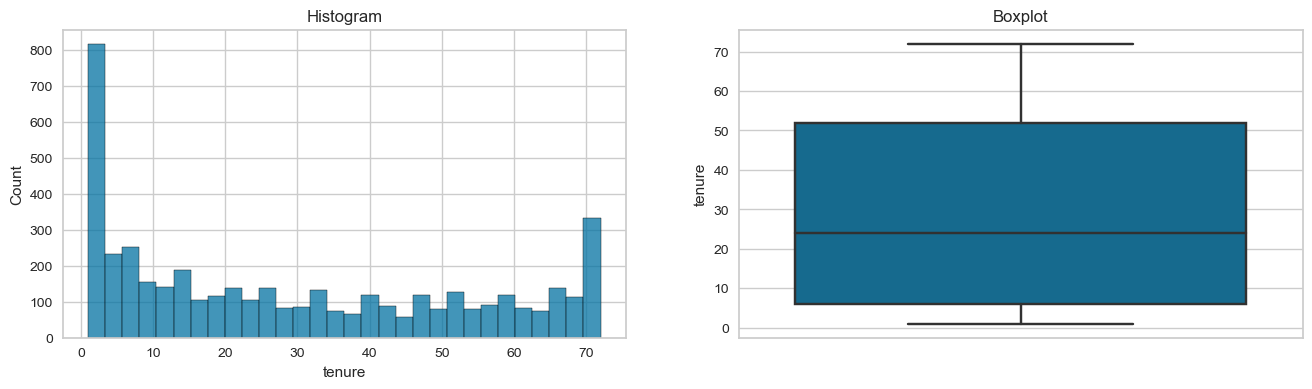

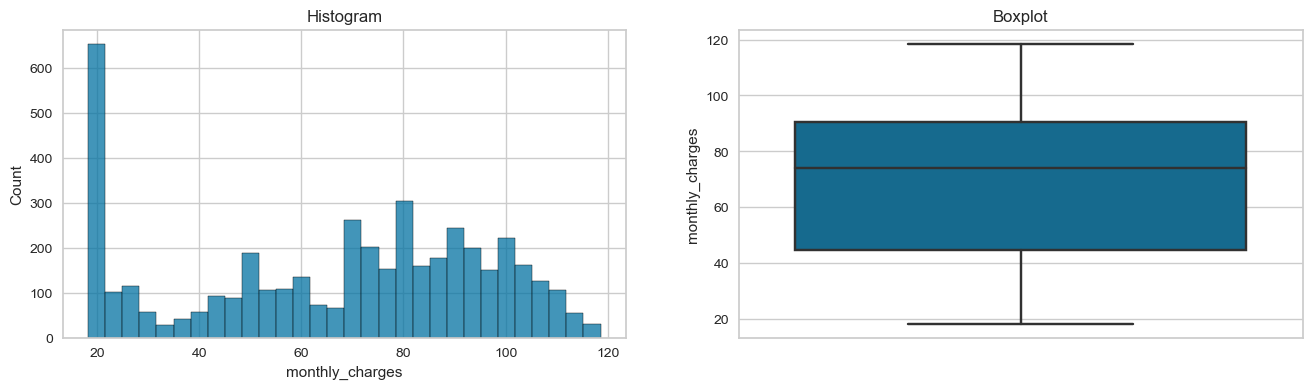

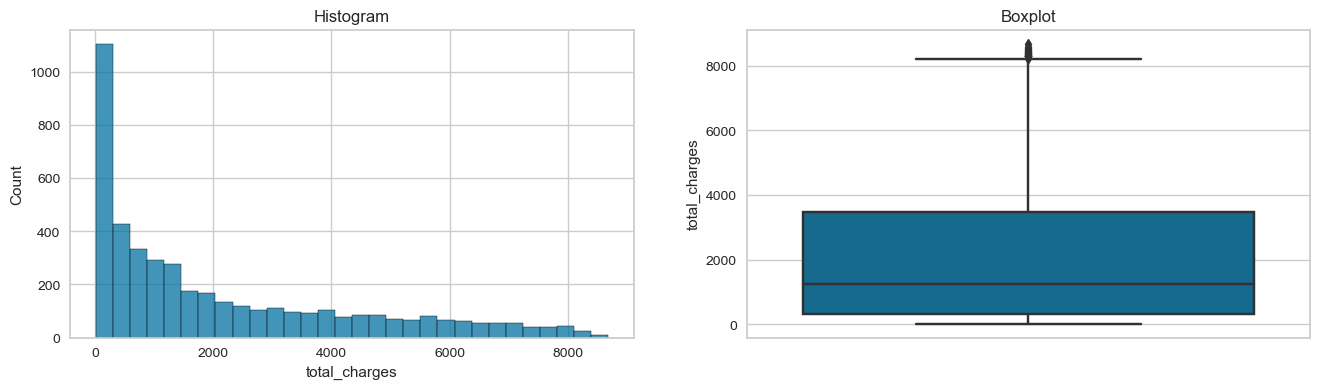

In [657]:
numCol = ['tenure',	'monthly_charges',	'total_charges']
for nCol in numCol:
    diagnostic_plots(df, nCol)

# Prediction Model

## - Fearure Selection

In [658]:
for x in df.columns:
    contingency_table4 = pd.crosstab(df[x],df['churn'])
    print(f'column {x} {stats.chi2_contingency(contingency_table4).pvalue}')

column Unnamed: 0 0.4929527393739349
column gender 0.3581415623596673
column senior_citizen 1.8521476472700925e-25
column partner 3.5778509656405413e-32
column dependents 2.1511582583192565e-36
column tenure 4.140829452618302e-129
column phone_service 0.41074520087377997
column multiple_lines 0.0331043292159368
column internet_service 2.1844118380528276e-128
column online_security 5.200826387714978e-153
column online_backup 7.848537444560684e-107
column device_protection 5.2994988001329886e-101
column tech_support 3.856825879570305e-145
column streaming_tv 1.857318096163576e-72
column streaming_movies 2.464076465658833e-73
column contract 3.07132364929811e-215
column paperless_billing 3.593967930250952e-46
column payment_method 4.684756307324047e-102
column monthly_charges 5.018174207658054e-11
column total_charges 0.27166956936014164
column churn 0.0
column monthly_charges_cat 1.0282731093629167e-62
column tenure_year 3.3865493938415696e-150


In [659]:
columns = ['senior_citizen','partner','dependents', 'internet_service',
        'online_security','online_backup','device_protection','tech_support',
        'streaming_tv', 'streaming_movies', 'contract',
        'paperless_billing', 'payment_method', 'monthly_charges', 'churn', 'tenure_year']
df = df.drop(columns=[col for col in df if col not in columns])
df.columns

Index(['senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'churn', 'tenure_year'],
      dtype='object')

## Split Features

In [660]:
df["churn"]= df["churn"].map({"No": 0, "Yes": 1})

In [661]:
X = df.drop('churn', axis =  1)
y = df['churn']

In [662]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)

print('Train Size :',X_train.shape)

print('Test Size :',X_test.shape)

X_train

Train Size : (3560, 15)
Test Size : (891, 15)


,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,tenure_year
3193,No,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,47.80,1
570,No,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),19.25,3
2216,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.45,6
2822,Yes,No,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,44.95,1
2254,Yes,No,No,DSL,No,No,No,Yes,No,No,Month-to-month,No,Mailed check,49.20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,Yes,No,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,71.00,1
1099,No,Yes,No,DSL,No,No,Yes,Yes,No,Yes,One year,Yes,Mailed check,69.55,4
2514,No,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.95,1
3606,No,No,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,74.95,1


## Split Columns

In [663]:
num = ['monthly_charges', 'tenure_year']
cat = ['senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 
       'contract', 'paperless_billing', 'payment_method']

In [664]:
X_train_num = X_train[num]
X_train_cat = X_train[cat]

X_test_num = X_test[num]
X_test_cat = X_test[cat]

In [665]:
df['monthly_charges'].skew()

-0.32718584371730813

In [666]:
df['tenure_year'].skew()

0.42050353311177596

## Feature Scaling

In [667]:
skewed_transformer = Pipeline([
    ('minmax', MinMaxScaler())
])

## Feature Encoding

In [668]:
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder())
])

## Merge Data

In [669]:
preprocessor = ColumnTransformer(transformers=[
    ('skewed', skewed_transformer, num),
    ('cat', categorical_transformer, cat)
])

## Model Definition

In [670]:
pipe_logreg = Pipeline([('preprocessor',preprocessor),('classifier',LogisticRegression())])
pipe_knn = Pipeline([('preprocessor',preprocessor),('classifier',KNeighborsClassifier())])
pipe_svm = Pipeline([('preprocessor',preprocessor),('classifier',SVC())]) 
pipe_dt = Pipeline([('preprocessor',preprocessor),('classifier',DecisionTreeClassifier())])
pipe_rf = Pipeline([('preprocessor',preprocessor),('classifier',RandomForestClassifier())])
pipe_boost = Pipeline([('preprocessor',preprocessor),('classifier',AdaBoostClassifier(LogisticRegression()))])
pipe_gradient = Pipeline([('preprocessor',preprocessor),('classifier',GradientBoostingClassifier())])

In [671]:
y_train

3193    1
570     0
2216    0
2822    1
2254    0
       ..
3335    1
1099    0
2514    0
3606    1
2575    0
Name: churn, Length: 3560, dtype: int64

## Model Training

In [214]:
pipe_logreg.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', LogisticRegression())])

In [215]:
pipe_knn.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', KNeighborsClassifier())])

In [216]:
pipe_svm.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', SVC())])

In [217]:
pipe_dt.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', DecisionTreeClassifier())])

In [218]:
pipe_rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', RandomForestClassifier())])

In [672]:
pipe_boost.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier',
                 AdaBoostClassifier(estimator=LogisticRegression()))])

In [304]:
pipe_gradient.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['monthly_charges',
                                                   'tenure_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', GradientBoostingClassifier())])

## Model Evaluation

In [675]:
def performance_check(clf, X, y):
  y_pred = clf.predict(X)

  return precision_score(y, y_pred)#, pos_label='Yes')

### Logistic Regression Evaluation

In [220]:
y_pred_train_logreg = pipe_logreg.predict(X_train)
y_pred_test_logreg = pipe_logreg.predict(X_test)

y_pred_train_logreg

array(['Yes', 'No', 'No', ..., 'No', 'Yes', 'No'], dtype=object)

In [221]:
print('Precision - Train : ', performance_check(pipe_logreg, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_logreg, X_test, y_test))

Precision - Train :  0.7257653061224489
Precision - Test  :  0.6828571428571428


### KNN Evaluation

In [222]:
y_pred_train_knn = pipe_knn.predict(X_train)
y_pred_test_knn = pipe_knn.predict(X_test)

y_pred_train_knn

array(['Yes', 'No', 'No', ..., 'No', 'Yes', 'No'], dtype=object)

In [223]:
print('Precision - Train : ', performance_check(pipe_knn, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_knn, X_test, y_test))

Precision - Train :  0.7617574257425742
Precision - Test  :  0.6240786240786241


### SVM Evaluation

In [224]:
y_pred_train_svm = pipe_svm.predict(X_train)
y_pred_test_svm = pipe_svm.predict(X_test)

y_pred_train_svm

array(['Yes', 'No', 'No', ..., 'No', 'Yes', 'No'], dtype=object)

In [225]:
print('Precision - Train : ', performance_check(pipe_svm, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_svm, X_test, y_test))

Precision - Train :  0.7317073170731707
Precision - Test  :  0.6775067750677507


### DecisionTree Evaluation

In [226]:
y_pred_train_dt = pipe_svm.predict(X_train)
y_pred_test_dt = pipe_svm.predict(X_test)

y_pred_train_dt

array(['Yes', 'No', 'No', ..., 'No', 'Yes', 'No'], dtype=object)

In [227]:
print('Precision - Train : ', performance_check(pipe_dt, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_dt, X_test, y_test))

Precision - Train :  0.9986648865153538
Precision - Test  :  0.5674931129476584


### RandomForest Evaluation

In [228]:
y_pred_train_rf = pipe_svm.predict(X_train)
y_pred_test_rf = pipe_svm.predict(X_test)

y_pred_train_rf

array(['Yes', 'No', 'No', ..., 'No', 'Yes', 'No'], dtype=object)

In [229]:
print('Precision - Train : ', performance_check(pipe_rf, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_rf, X_test, y_test))

Precision - Train :  0.9895150720838795
Precision - Test  :  0.6430594900849859


### AdaBoost Evaluation

In [676]:
y_pred_train_boost = pipe_boost.predict(X_train)
y_pred_test_boost = pipe_boost.predict(X_test)

y_pred_train_boost

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [677]:
print('Precision - Train : ', performance_check(pipe_boost, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_boost, X_test, y_test))

Precision - Train :  0.7145510835913312
Precision - Test  :  0.6793478260869565


### GradientBoosting Evaluation

In [305]:
y_pred_train_gradient = pipe_gradient.predict(X_train)
y_pred_test_gradient = pipe_gradient.predict(X_test)

y_pred_train_gradient

array(['Yes', 'No', 'No', ..., 'No', 'Yes', 'No'], dtype=object)

In [306]:
print('Precision - Train : ', performance_check(pipe_gradient, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_gradient, X_test, y_test))

Precision - Train :  0.7498371335504886
Precision - Test  :  0.6896551724137931


## Model Improvement

## Logistic Regression Grid Search

In [230]:
penalty = ['l2','elasticnet',None]
tol = [0.00001]
C = [0.25, 0.5, 0.75]
fit_intercept = [True,False]
random_state = [10]
solver = ['lbfgs','liblinear','sag']
max_iter = [25,50,75]
multi_class = ['ovr','auto','multinomial']

logreg_search_params = {'classifier__penalty':penalty,'classifier__tol':tol,
                        'classifier__C':C,'classifier__fit_intercept':fit_intercept,
                        'classifier__random_state':random_state,'classifier__solver':solver,
                        'classifier__max_iter':max_iter,'classifier__multi_class':multi_class}
logreg_search_params

{'classifier__penalty': ['l2', 'elasticnet', None],
 'classifier__tol': [1e-05],
 'classifier__C': [0.25, 0.5, 0.75],
 'classifier__fit_intercept': [True, False],
 'classifier__random_state': [10],
 'classifier__solver': ['lbfgs', 'liblinear', 'sag'],
 'classifier__max_iter': [25, 50, 75],
 'classifier__multi_class': ['ovr', 'auto', 'multinomial']}

In [231]:
logreg_gridcv = GridSearchCV(estimator=pipe_logreg,param_grid=logreg_search_params,
                                 cv=5,
                                 n_jobs=-1,
                                 scoring='precision')
logreg_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
             n_jobs=-1,
             param_grid={'classifier__C': [0.25, 0.5, 0.75],
                         'classifier__fit_intercept': [True, False],
                         'classifier__max_iter': [25, 50, 75],
                         'classifier__multi_class': ['ovr', 'auto',
                                                     'multinomial'],
                         'classifier__penalty': ['l2', 'elasticnet', None],
                         'classifier__random_state': [10],
                         'classifier__solver': ['lbfgs', 'liblinear', 'sag'],
                         'classifier__tol': [1e-05]},
             scoring='precision')

In [232]:
logreg_gridcv.best_params_

{'classifier__C': 0.25,
 'classifier__fit_intercept': True,
 'classifier__max_iter': 25,
 'classifier__multi_class': 'ovr',
 'classifier__penalty': 'l2',
 'classifier__random_state': 10,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 1e-05}

In [233]:
logreg_gridcv_best = logreg_gridcv.best_estimator_

In [234]:
y_pred_test_logreg_final = logreg_gridcv_best.predict(X_test)
y_pred_train_logreg_final = logreg_gridcv_best.predict(X_train)
print('Train : ', performance_check(logreg_gridcv_best, X_train, y_train))
print('Test  : ', performance_check(logreg_gridcv_best, X_test, y_test))

Train :  0.722678458622868
Test  :  0.6901408450704225


### SVM Gridsearch

In [255]:
C = [0.25,0.5,0.75]
kernel = ['linear','rbf','poly']
degree = [1,2]
gamma = ['scale','auto']
break_ties = [False]
max_iter = [-1]
cache_size = [7,8,9,10]
decision_function_shape = ['ovo','ovr']
random_state = [10]

svm_search_params = {'classifier__C' : C, 'classifier__kernel' : kernel, 'classifier__degree' : degree, 'classifier__gamma' : gamma, 'classifier__break_ties' : break_ties,
                       'classifier__max_iter' : max_iter, 'classifier__cache_size' : cache_size, 'classifier__decision_function_shape' : decision_function_shape, 'classifier__random_state' : random_state}
svm_search_params

{'classifier__C': [0.25, 0.5, 0.75],
 'classifier__kernel': ['linear', 'rbf', 'poly'],
 'classifier__degree': [1, 2],
 'classifier__gamma': ['scale', 'auto'],
 'classifier__break_ties': [False],
 'classifier__max_iter': [-1],
 'classifier__cache_size': [7, 8, 9, 10],
 'classifier__decision_function_shape': ['ovo', 'ovr'],
 'classifier__random_state': [10]}

In [256]:
svm_gridcv = GridSearchCV(estimator=pipe_svm,param_grid=svm_search_params,
                                 cv=5,
                                 n_jobs=-1,
                                 scoring='precision')
svm_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
             param_grid={'classifier__C': [0.25, 0.5, 0.75],
                         'classifier__break_ties': [False],
                         'classifier__cache_size': [7, 8, 9, 10],
                         'classifier__decision_function_shape': ['ovo', 'ovr'],
                         'classifier__degree': [1, 2],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['linear', 'rbf', 'poly'],
                         'classifier__max_iter': [-1],
                         'classifier__random_state': [10]},
             scoring='precision')

In [257]:
svm_gridcv.best_params_

{'classifier__C': 0.25,
 'classifier__break_ties': False,
 'classifier__cache_size': 7,
 'classifier__decision_function_shape': 'ovo',
 'classifier__degree': 1,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'linear',
 'classifier__max_iter': -1,
 'classifier__random_state': 10}

In [258]:
svm_gridcv_best = svm_gridcv.best_estimator_

In [259]:
y_pred_test_svm_final = svm_gridcv_best.predict(X_test)
y_pred_train_svm_final = svm_gridcv_best.predict(X_train)
print('Train : ', performance_check(svm_gridcv_best, X_train, y_train))
print('Test  : ', performance_check(svm_gridcv_best, X_test, y_test))

Train :  0.6985507246376812
Test  :  0.6550868486352357


### RandomForest Grid Search


In [262]:
n_estimators = [50,100,150]
criterion = ['gini','entropy','log_loss']
max_depth = [10,None]
min_samples_split = [0.5,1,2,]
min_samples_leaf = [0.5,1,1.5]
max_features = ['sqrt','log2',None]
random_state = [10]

rf_search_params = {'classifier__n_estimators':n_estimators,'classifier__criterion':criterion,
                    'classifier__max_depth':max_depth,'classifier__min_samples_split':min_samples_split,
                    'classifier__min_samples_leaf':min_samples_leaf,'classifier__max_features':max_features,
                    'classifier__random_state':random_state}
rf_search_params

{'classifier__n_estimators': [50, 100, 150],
 'classifier__criterion': ['gini', 'entropy', 'log_loss'],
 'classifier__max_depth': [10, None],
 'classifier__min_samples_split': [0.5, 1, 2],
 'classifier__min_samples_leaf': [0.5, 1, 1.5],
 'classifier__max_features': ['sqrt', 'log2', None],
 'classifier__random_state': [10]}

In [263]:
rf_gridcv = GridSearchCV(estimator=pipe_rf,param_grid=rf_search_params,
                                 cv=5,
                                 n_jobs=-1,
                                 scoring='precision')
rf_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [10, None],
                         'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__min_samples_leaf': [0.5, 1, 1.5],
                         'classifier__min_samples_split': [0.5, 1, 2],
                         'classifier__n_estimators': [50, 100, 150],
                         'classifier__random_state': [10]},
             scoring='precision')

In [269]:
rf_gridcv.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 10,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 0.5,
 'classifier__min_samples_split': 0.5,
 'classifier__n_estimators': 50,
 'classifier__random_state': 10}

In [268]:
rf_gridcv_best = rf_gridcv.best_estimator_

In [267]:
y_pred_test_svm_final = rf_gridcv_best.predict(X_test)
y_pred_train_svm_final = rf_gridcv_best.predict(X_train)
print('Train : ', performance_check(rf_gridcv_best, X_train, y_train))
print('Test  : ', performance_check(rf_gridcv_best, X_test, y_test))

Train :  0.0
Test  :  0.0


## AdaBoost Grid Search

In [678]:
n_estimators = [1]
learning_rate = [0.001, 0.01, 0.1]
algorithm = ['SAMME','SAMME.R']
random_state = [10]

boost_search_params = {'classifier__n_estimators':n_estimators,'classifier__learning_rate':learning_rate,
                       'classifier__algorithm':algorithm,'classifier__random_state':random_state}
boost_search_params

{'classifier__n_estimators': [1],
 'classifier__learning_rate': [0.001, 0.01, 0.1],
 'classifier__algorithm': ['SAMME', 'SAMME.R'],
 'classifier__random_state': [10]}

In [679]:
boost_gridcv = GridSearchCV(estimator=pipe_boost,param_grid=boost_search_params,
                                 cv=5,
                                 n_jobs=-1,
                                 scoring='precision')
boost_gridcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'contract',
                                                                          'paperless_billing',
                                                                          'payment_method'])])),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=LogisticRegression()))]),
             n_jobs=-1,
             param_grid={'classifier__algorithm': ['SAMME', 'SAMME.R'],
                         'classifier__learning_rate': [0.001, 0.01, 0.1],
                         'classifier__n_estimators': [1],
                         'classifier__random_state': [10]},
             scoring='precision')

In [680]:
boost_gridcv.best_params_

{'classifier__algorithm': 'SAMME',
 'classifier__learning_rate': 0.001,
 'classifier__n_estimators': 1,
 'classifier__random_state': 10}

In [681]:
boost_gridcv_best = boost_gridcv.best_estimator_

In [682]:
y_pred_train_boost = boost_gridcv.predict(X_train)
y_pred_test_boost = boost_gridcv.predict(X_test)
print('Precision - Train : ', performance_check(boost_gridcv_best, X_train, y_train))
print('Precision - Test  : ', performance_check(boost_gridcv_best, X_test, y_test))

Precision - Train :  0.7952522255192879
Precision - Test  :  0.828125


In [683]:
precision_boost_cross_val = cross_val_score(boost_gridcv_best,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="precision",
                                     error_score='raise')

In [684]:
print('Precision Score - All - Cross Validation  : ', precision_boost_cross_val)
print('Precision - Mean - Cross Validation : ', precision_boost_cross_val.mean())
print('Precision - Std - Cross Validation  : ', precision_boost_cross_val.std())
print('Precision Score - Range of Test-Set       : ', (precision_boost_cross_val.mean()-precision_boost_cross_val.std()) , '-', (precision_boost_cross_val.mean()+precision_boost_cross_val.std()))

Precision Score - All - Cross Validation  :  [0.83216783 0.8013245  0.78813559 0.74626866 0.796875  ]
Precision - Mean - Cross Validation :  0.7929543170831694
Precision - Std - Cross Validation  :  0.02766189625050376
Precision Score - Range of Test-Set       :  0.7652924208326657 - 0.8206162133336732


## GradientBoosting Grid Search

In [490]:
# loss = ['log_loss','exponential']
# subsample = [0.5,1,1.5,2]
# n_estimators = [25,50,75,100]
# learning_rate = [0.5,1,1.5,2]
# criterion = ['friedman_mse','squared_error']
# min_samples_split = [0.5,0.75,1,2]
# min_samples_leaf = [0.5,0.75,1]
# max_depth = [2,3,4,None]
# random_state = [10]

loss = ['log_loss','exponential']
subsample = [0.5, 1]
n_estimators = [100]
learning_rate = [0.1]
criterion = ['friedman_mse','squared_error']
min_samples_split = [2]
min_samples_leaf = [1]
max_depth = [3]
random_state = [21]

gradient_search_params = {'classifier__loss':loss,
                          'classifier__subsample':subsample,
                          'classifier__criterion':criterion,
                          'classifier__min_samples_split':min_samples_split,
                          'classifier__min_samples_leaf':min_samples_leaf,
                          'classifier__max_depth':max_depth,
                          'classifier__n_estimators':n_estimators,
                          'classifier__learning_rate':learning_rate,
                          'classifier__random_state':random_state}
gradient_search_params

{'classifier__loss': ['log_loss', 'exponential'],
 'classifier__subsample': [0.5, 1],
 'classifier__criterion': ['friedman_mse', 'squared_error'],
 'classifier__min_samples_split': [2],
 'classifier__min_samples_leaf': [1],
 'classifier__max_depth': [3],
 'classifier__n_estimators': [100],
 'classifier__learning_rate': [0.1],
 'classifier__random_state': [21]}

In [491]:
gradient_gridcv = GridSearchCV(estimator=pipe_gradient,param_grid=gradient_search_params,
                                 cv=3,
                                 n_jobs=-1,
                                 scoring='precision')
gradient_gridcv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['monthly_charges',
                                                                          'tenure_year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          't...
             param_grid={'classifier__criterion': ['friedman_mse',
                                                   'squared_error'],
                         'classifier__learning_rate': [0.1],
                         'classifier__loss': ['log_loss', 'exponential'],
                         'classifier__max_depth': [3],
                         'classifier__min_samples_leaf': [1],
                         'classifier__min_samples_split': [2],
                         'classifier__n_estimators': [100],
                         'classifier__random_state': [21],
                         'classifier__subsample': [0.5, 1]},
             scoring='precision')

In [492]:
gradient_gridcv.best_params_

{'classifier__criterion': 'friedman_mse',
 'classifier__learning_rate': 0.1,
 'classifier__loss': 'log_loss',
 'classifier__max_depth': 3,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 100,
 'classifier__random_state': 21,
 'classifier__subsample': 0.5}

In [493]:
gradient_gridcv_best = gradient_gridcv.best_estimator_

In [494]:
# y_pred_train_gradient = gradient_gridcv_best.predict(X_train)
# y_pred_test_gradient = gradient_gridcv_best.predict(X_test)
# y_pred_train_gradient
print('Precision - Train : ', performance_check(gradient_gridcv_best, X_train, y_train))
print('Precision - Test  : ', performance_check(gradient_gridcv_best, X_test, y_test))

Precision - Train :  0.7487113402061856
Precision - Test  :  0.7005813953488372
